In [2]:
import pandas as pd
%matplotlib inline

/Users/essex/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/essex/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
_LINEAR_WEIGHT_SLOPE = 0.3

In [4]:
def profit_and_loss2(sc,tolerate=0.03):
    navline=sc.copy()
    navindex=navline.index
    navlength=len(navline.index)
    turning_point=[]

    #给定初始状态
    init_point=0
    init_status=0
    cur_high=float('-inf')
    cur_high_point=-1
    cur_low=float('inf')
    cur_low_point=-1

    #生成初始状态
    tmp_cnt=0
    for n in range(len(navindex)):
        cur_value = navline.ix[navindex[n]]
        if navline.ix[navindex[n]] >navline.ix[navindex[n+1]]:  #亏损状态
            init_point=tmp_cnt+1
            cur_low=cur_value
            init_status=-1
            turning_point.append((init_point,init_status))
            break
        elif navline.ix[navindex[n]]<navline.ix[navindex[n+1]]:
            init_point=tmp_cnt+1
            cur_high = cur_value
            init_status=1
            turning_point.append((init_point, init_status))
            break
        tmp_cnt+=1


    endflag=False
    loop_cnt=0
    while True:

        if endflag or loop_cnt>100:break
        # 开始正式的遍历
        tmp_cnt = init_point
        cur_status = init_status
        for n in navindex[init_point:]:
            cur_value=navline[n]

            if cur_status==1:   #寻找盈利区终点

                if cur_value>cur_high:  # 是否产生新高点
                    cur_high=cur_value
                    cur_high_point=tmp_cnt
                elif cur_value<cur_high*(1-tolerate):  #终结条件：当前点比最高点低3%以上切换状态
                    cur_status=-1
                    cur_high=float('-inf')
                    turning_point.append((cur_high_point,cur_status))
                    init_point=cur_high_point
                    init_status=cur_status
                    break

            elif cur_status==-1:  #寻找亏损区终点

                if cur_value < cur_low:
                    cur_low = cur_value
                    cur_low_point = tmp_cnt
                elif cur_value > cur_low * (1 + tolerate):  # 终结条件：当前点比最高点低3%以上切换状态
                    cur_status = 1
                    cur_low = float('inf')
                    turning_point.append((cur_low_point, cur_status))
                    init_point = cur_low_point
                    init_status = cur_status
                    break

            if n==navindex[-1]:
                endflag=True
            tmp_cnt += 1

        loop_cnt+=1

    #for n
    #处理最后一个点
    if turning_point[-1][0] < navlength - 1 and len(turning_point) > 1:
        turning_point.append((navlength - 1, turning_point[-2][1]))



    return turning_point


In [5]:
def get_high_low_point(df):
    toleratemax=0.1
    toleratemin=0.021
    tolerate=toleratemax
    step=0.01
    while True:
        if tolerate<=toleratemin:
            break

        turning_points=profit_and_loss2(df,tolerate)
        if len(turning_points)<9:
            tolerate-=step
        else:
            break
        #print tolerate
        if tolerate<=toleratemin:
            break

    return turning_points[1:-1],tolerate

In [6]:
def _calcline(a,b):
    k=(b[1]-a[1])/(b[0]-a[0])
    c=a[1]-k*a[0]
    return k,c

def _is_upper_or_on(p,line):
    k=line[0]
    c=line[1]
    diff=p[1]-k*p[0]-c
    if diff>=-0.01:
        return True
    else:
        return False

def _is_lower_or_on(p,line):
    k = line[0]
    c = line[1]
    diff = p[1] - k * p[0] - c
    if diff > 0.01:
        return False
    else:
        return True

def _calc_var(points,line):
    k = line[0]
    c = line[1]
    var=0
    for p in points:
        diff = p[1] - k * p[0] - c
        var += p[2] * diff**2
    return var

In [7]:
def get_support(support_points):

    support_comb = []
    for n in range(len(support_points)):
        for m in range(n + 1, len(support_points)):
            support_comb.append((n, m))

    support_line = []
    for n in support_comb:
        tmp_point1 = support_points[n[0]]
        tmp_point2 = support_points[n[1]]
        line = _calcline(tmp_point1, tmp_point2)
        tmp_judge = True
        for m in support_points:
            tmp_judge *= _is_upper_or_on(m, line)
        if tmp_judge:
            support_line.append(line)

    if len(support_line)==0:
        return None

    mincnt = -1
    minvar = float('inf')
    for n in range(len(support_line)):
        tmp_var = _calc_var(support_points, support_line[n])
        #print tmp_var
        if tmp_var < minvar:
            minvar = tmp_var
            mincnt = n

    #print 'min', minvar,mincnt

    support = support_line[mincnt]

    return support

def get_block(block_points):

    block_comb = []
    for n in range(len(block_points)):
        for m in range(n + 1, len(block_points)):
            block_comb.append((n, m))

    block_line=[]
    for n in block_comb:
        tmp_point1=block_points[n[0]]
        tmp_point2=block_points[n[1]]
        line=_calcline(tmp_point1,tmp_point2)
        tmp_judge=True
        for m in block_points:
            tmp_judge *=_is_lower_or_on(m,line)
            #print _is_lower_or_on(m,line)
        #print n,tmp_judge
        if tmp_judge:
            block_line.append(line)
    #print block_comb
    #print block_points

    if len(block_line)==0:
        return None

    mincnt = -1
    minvar = float('inf')
    for n in range(len(block_line)):
        tmp_var = _calc_var(block_points, block_line[n])

        if tmp_var < minvar:
            minvar = tmp_var
            mincnt = n


    block = block_line[mincnt]

    return block

In [8]:
def _split_days(high,low,drawdays,extenddays):
    """输出计算区，延长区"""
    assert len(high)>=drawdays+extenddays
    extend_sc = high.iloc[-extenddays:]
    high_sc = high.iloc[-extenddays-drawdays:-extenddays]
    low_sc = low.iloc[-extenddays-drawdays:-extenddays]

    return high_sc,low_sc,extend_sc,len(high_sc)

def _split_date(high,low,startdate,enddate,extenddays,minbars=20):
    """最小计算bar，20天"""
    #extend_sc = HIGH.ix[enddate:].iloc[:extend_days]
    high_sc = high.ix[startdate:enddate]
    assert len(high_sc)>=minbars
    low_sc = low.ix[startdate:enddate]
    rest_sc = high.ix[enddate:]
    if enddate==rest_sc.index[0]:
        if len(rest_sc)<=extenddays+1:
            extend_sc=rest_sc.iloc[1:]
        else:
            extend_sc=rest_sc.iloc[1:1+extenddays]
    else:
        if len(rest_sc)<=extenddays:
            extend_sc=rest_sc
        else:
            extend_sc=rest_sc.iloc[:extenddays]

    return high_sc,low_sc,extend_sc,len(high_sc)

In [9]:
def _get_weight_method(method_name):
    if method_name=='no':
        return lambda x:1.
    elif method_name=='linear_new_first':
        return lambda x:_LINEAR_WEIGHT_SLOPE*x

In [10]:
def support_block(indf,split_type,split_paras,method_name='no'):

    """
        重新规划下计算参数
    """

    high = indf['high']
    low = indf['low']

    try:
        if split_type=='days':
            high_sc,low_sc, extend_sc, extend_start = _split_days(high,low,split_paras['drawdays'],split_paras['extenddays'])
        elif split_type=='date':
            high_sc,low_sc, extend_sc, extend_start = _split_date(high,low,split_paras['startdate'],split_paras['enddate'],
                                                            split_paras['extenddays'])
    except AssertionError:
        return pd.DataFrame(),

    turning_points_high, tolerate = get_high_low_point(high_sc)
    turning_points_low, tolerate = get_high_low_point(low_sc)

    # 添加权重
    weight_func = _get_weight_method(method_name)

    support_points = []
    for n in turning_points_low:
        tmp_y = low_sc.iloc[n[0]]
        if n[1] == 1:
            support_points.append((n[0], tmp_y, weight_func(n[0])))

    block_points = []
    for n in turning_points_high:
        tmp_y = high_sc.iloc[n[0]]
        if n[1] == -1:
            block_points.append((n[0], tmp_y,weight_func(n[0])))

    block_line=get_block(block_points)
    if not block_line:
        block_line = (0,high_sc.max())
    support_line=get_support(support_points)
    if not support_line:
        support_line = (0, low_sc.min())

    df = pd.DataFrame()

    df['high'] = high_sc
    df['x'] = range(len(high_sc))
    df['block'] = df['x'] * block_line[0] + block_line[1]
    df['support'] = df['x'] * support_line[0] + support_line[1]
    df = df.drop('x', axis=1)

    extend_df = pd.DataFrame()
    extend_df['high'] = extend_sc
    extend_df['x'] = range(extend_start,extend_start+len(extend_sc))
    #extend_df['block_extend'] = extend_df['x']*block_line[0] + block_line[1]
    #extend_df['support_extend'] = extend_df['x'] * support_line[0] + support_line[1]

    extend_df['block'] = extend_df['x'] * block_line[0] + block_line[1]
    extend_df['support'] = extend_df['x'] * support_line[0] + support_line[1]

    extend_df=extend_df.drop('x',axis=1)

    return df.combine_first(extend_df).drop('high',axis=1).dropna(how='all')


In [11]:
SUPPORT_BLOCK_WEIGHT_METHOD = 'linear_new_first'

SUPPORT_BLOCK_DRAWDAYS = 60

SUPPORT_BLOCK_EXTENDDAYS = 1

In [17]:
import os


In [19]:
os.listdir('cache_data/')

['000004.SZ_20200701_20201124.hdf', '000001.SZ_20200701_20201124.hdf']

In [12]:
df = pd.read_hdf('cache_data/000004.SZ_20200701_20201124.hdf','data')

In [13]:
df=df[['trade_date','open','high','low','close']]
df.set_index('trade_date',inplace=True)
df.sort_index(inplace=True)

In [14]:
df

,open,high,low,close
trade_date,,,,
20200701,29.80,30.82,29.60,30.20
20200702,30.28,30.28,28.70,29.45
20200703,29.45,29.49,28.38,28.46
20200706,28.46,31.28,28.40,30.47
20200707,31.00,31.69,30.10,31.25
...,...,...,...,...
20201118,28.36,30.15,28.28,29.65
20201119,30.00,32.62,29.40,32.62
20201120,32.42,33.33,30.55,31.46


In [15]:
drawdays=40
r=support_block(df,'days',{'drawdays': drawdays,
                                            'extenddays': SUPPORT_BLOCK_EXTENDDAYS},
                                    SUPPORT_BLOCK_WEIGHT_METHOD)

/Users/essex/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/Users/essex/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [18]:
x=pd.concat([df,r],axis=1)

/Users/essex/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


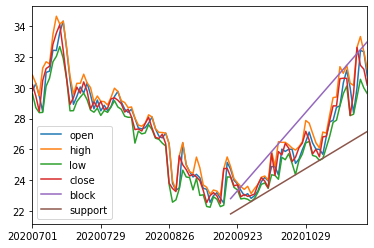

In [19]:
x.plot()